In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.v2 import ToTensor, Lambda

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Defining transform

In [3]:
ROTATION_RANGE_MIN = 0
ROTATION_RANGE_MAX = 150
FLIPPING = 0.5

BRIGHTNESS = 0.2
CONTRAST = 0.2
SATURATION = 0.2
HUE = 0.1

In [4]:
# https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde
# about transforms and etc

MEAN = [0.5450, 0.4435, 0.3436]
STD = [0.2302, 0.2409, 0.2387]
# Transform to convert images and resize them, so we could use pre-trained models
# Note apply only to the training set!
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),

    # Data augmentation
    transforms.ColorJitter(brightness = BRIGHTNESS, contrast = CONTRAST, saturation = SATURATION, hue = HUE), # different brigtness, contrast
    transforms.RandomRotation(degrees=(ROTATION_RANGE_MIN, ROTATION_RANGE_MAX)), # rotation of the image

    transforms.RandomHorizontalFlip(p=FLIPPING),
    transforms.RandomVerticalFlip(p=FLIPPING),


])

In [5]:
def data_loading():
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

data_loading()

100%|██████████| 5.00G/5.00G [03:07<00:00, 26.7MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

In [7]:
len(train_data), len(test_data)

(75750, 25250)

We have 75750 training images and 25250 testing images

In [8]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 23)

In [10]:
print(f"Image shape: {image.shape}")
print(f"Class label: {class_names[label]}")

Image shape: torch.Size([3, 224, 224])
Class label: churros


In [13]:
len(train_data.classes)

101

# Visualize image

In [14]:
print(image.squeeze().shape)

torch.Size([3, 224, 224])


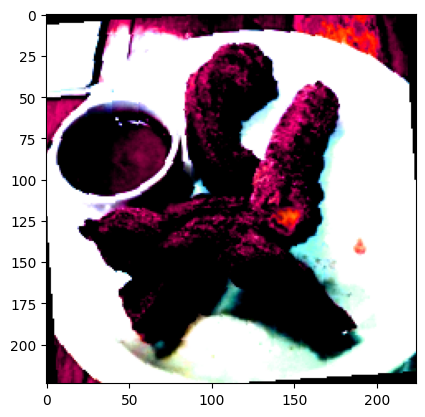

In [15]:
# transform an image from (C, H, W) to (H, W, C) to visualize it
image_permute = image.permute(1, 2, 0)
plt.imshow(image_permute)

# Plot random images

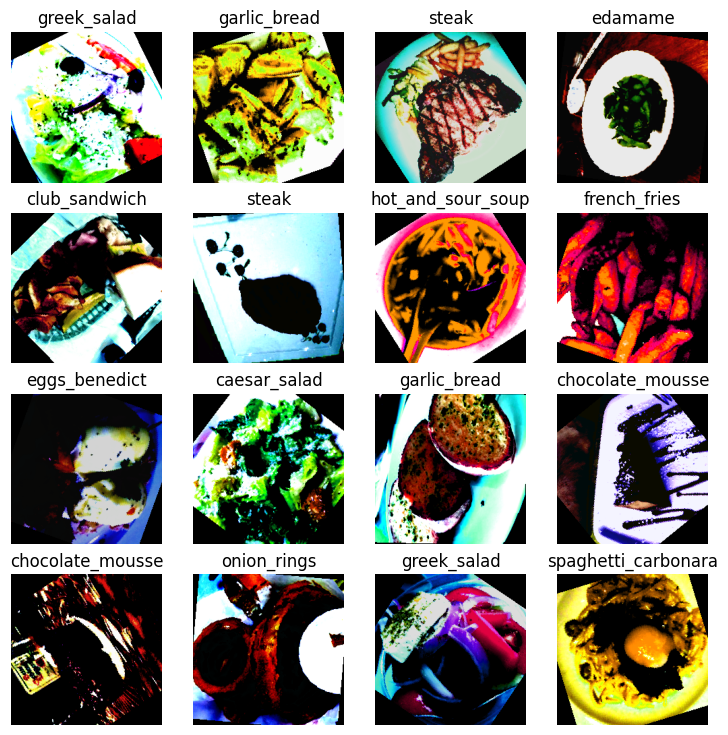

In [16]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis("off")

### Calculates global normalization stastics.
This will help to normalize pixel values, increase convergence of a model

In [ ]:
"""
from tqdm import tqdm
train_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)

mean = torch.zeros(3, device=device)
std = torch.zeros(3, device=device)
nb_samples = 0.

for data, _ in tqdm(train_loader, total=len(train_loader)):
    # Put data to GPU
    data = data.to(device)
    batch_samples = data.size(0)
    # Flatten height and width
    data = data.view(batch_samples, data.size(1), -1)
    # Calculate mean and std
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Calculate global mean and std
mean /= nb_samples
std /= nb_samples

print("Global Mean:", mean)
print("Global Std:", std)
"""

'\nfrom tqdm import tqdm\ntrain_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)\n\nmean = torch.zeros(3, device=device)\nstd = torch.zeros(3, device=device)\nnb_samples = 0.\n\nfor data, _ in tqdm(train_loader, total=len(train_loader)):\n    # Put data to GPU\n    data = data.to(device)\n    batch_samples = data.size(0)\n    # Flatten height and width\n    data = data.view(batch_samples, data.size(1), -1)\n    # Calculate mean and std\n    mean += data.mean(2).sum(0)\n    std += data.std(2).sum(0)\n    nb_samples += batch_samples\n\n# Calculate global mean and std\nmean /= nb_samples\nstd /= nb_samples\n\nprint("Global Mean:", mean)\nprint("Global Std:", std)\n'

## Building Custom CNN

In [17]:
DROPOUT = 0.25

In [18]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes = 101):
        super().__init__()

        # Original [3, 224, 224]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # dimensionality reduction [64, 112, 112]
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Second layer [128, 56, 56]
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third layer [256, 28, 28]
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fourth layer [512, 14, 14]
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Dropout
        self.dropout = nn.Dropout(p=DROPOUT)

        # Fully connected layer
        # Spatial dimension was reduced from 224(original) -> 112 -> 56 -> 28 -> 14
        # feature map 14x14, 512 channels
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Note that deeper we go the more complex features model can recognize
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.adaptive_pool(x) #[batch, 512, 1, 1]
        # Flatten [batch, 512]
        x = x.view(x.size(0), -1)
        x= self.dropout(x)
        x = self.fc2(x)

        return x

Image shape torch.Size([3, 224, 224])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
